In [1]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import ipdb
import re
from datasets import load_dataset
from diversity import compression_ratio, homogenization_score, ngram_diversity_score, extract_patterns, get_pos, pos_patterns, token_patterns
import json

import matplotlib.pyplot as plt
# import mplcursors
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid', context='notebook', rc={'figure.figsize':(14,10)}, font_scale=2)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('chained_assignment',None)

# Set random seeds for reproducibility on a specific machine
random.seed(1)
np.random.seed(1)
np.random.RandomState(1)
np.set_printoptions(precision=3)

## Dolly human written responses diversity analysis

In [2]:
with open('../data/sample_personas.txt', 'r') as f:
    personas = [x.strip() for x in f.readlines()]
personas[2]

'a Spanish-speaking patient with severe myopia interested in LASIK eye surgery'

In [3]:
dolly = load_dataset("databricks/databricks-dolly-15k")["train"].filter(lambda row: row['category']=='creative_writing').to_pandas()
sample = pd.read_csv('../data/dolly_creative_prompts_sample.tsv', sep='\t')

In [4]:
sample.head()

,index,instruction
0,525,Please propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.
1,172,"Write a paragraph to refute a claim by a colleague that ancient structures such as Stonehenge, the Great Pyramid are evidence of UFO activities on Earth"
2,109,What is the best way to answer an interview question?
3,37,Write the first paragraph of an advertising brochure describing an hotel nearby the Annecy Lake in France
4,295,"Write an intro to a meetup about music, medicine, and machines"


In [5]:
sample['response'] = sample['index'].apply(lambda x: dolly.loc[x, 'response'])
sample['prompt_id'] = [i for i in range(len(sample))]
sample.head()

,index,instruction,response,prompt_id
0,525,Please propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"Dear Mum, I would like to talk to you about the monthly money I get for my studies. I am very grateful that you support me financially during my studies. At the same time, I feel that the current amount is a little bit too low in order to sustain myself. I estimated my monthly expenses and it seems like the money is not enough. We can go through the details if you want. I want to ask you if you can increase the amount so that I can cover my expenses. I understand if you cannot do this or have other reasons against this. However, I want you to know that if you do not increase my monthly money, I will be forced to work part-time next to my studies. There is research that shows that students who work part-time have worse grades than people who do not have to work part-time to afford their studies. I would love to dedicate my full time to my studies to get the best grades and learning outcomes possible; thus, I would prefer not to work part-time. What do you think?",0
1,172,"Write a paragraph to refute a claim by a colleague that ancient structures such as Stonehenge, the Great Pyramid are evidence of UFO activities on Earth","There are several strong arguments against concluding that alien races built the structures like the Stonehenge or the Pyramids. First, there is evidence that these magnificent structures were built by humans. For example, tombs of the pyramid builders were found in the vicinity of the Great Pyramind (with human remains!). The technology to move and assemble the massive stones of the Stonehenge has been shown to be available to humans at that time. Second, given that space is vast the chance of finding one tiny planet among billions is infinitesimal. If alien intelligence had indeed found our one inhabited planet they are unlikely to have just created couple of structures and avoided any further contact with Earth and its inhabitants. In science, Occam’s Razor (“the best explanation is the simplest one”) is a guiding principle and until there is much more evidence of alien visitation it would be inadvisable to jump to a conclusion that aliens built these structures.",1
2,109,What is the best way to answer an interview question?,"The first recommended step is to ask clarifying questions to ensure you understand the question correctly and gather the requirements needed to answer effectively. If it is a mathematical or computer science question, go ahead and work your way through the problem while you verbalize your thought process along the way. If it is a situation question, you should use the STAR method. 1. Situation - set the scene and provide context, 2. Task - describe what was needed to be done and why, 3. Action - explain what action you took, and 4. Result - describe the result of your actions and what you learned from the experience",2
3,37,Write the first paragraph of an advertising brochure describing an hotel nearby the Annecy Lake in France,"This fantastic hotel is ideally located, minutes away from the Annecy Lake, one of the purest in Europe. The water temperature reaches 27 degrees celcius at the peak season, allowing the guests to swim and enjoy several water activities including wake surf and pedalo. Finally, this region is known for being the home of several cheese specialties like ""Raclette"" and ""Tartiflette"" to name a few.",3
4,295,"Write an intro to a meetup about music, medicine, and machines","Music, Medicine, and Machines\n\nJoin us for an imaginative, authentic, and offbeat networking experience that will advance your knowledge of the technologies that impact the health and well-being of our human condition. To make things interesting (but keep things real), our meetup incorporates an element of music to remind us, first and foremost, we want to advance technology for t

In [57]:
prompts = sample['instruction'].values.tolist()

In [6]:
human_responses = sample['response'].values.tolist()

In [7]:
cr = compression_ratio(human_responses, 'gzip')
nds = ngram_diversity_score(human_responses, 4)
print(f"CR: {cr}, NDS: {nds}")

CR: 2.508, NDS: 3.026


In [8]:
joined_pos, tuples = get_pos(human_responses)

In [9]:
ngrams_pos = token_patterns(joined_pos, 5, 10)
ngrams_pos

[('DT NN IN DT NN', 53),
 ('NN IN DT JJ NN', 49),
 ('IN DT NN IN DT', 43),
 ('DT JJ NN IN DT', 43),
 ('IN DT JJ NN IN', 33),
 ('IN DT JJ NN .', 32),
 ('JJ NN IN DT NN', 30),
 ('IN DT NN IN NN', 28),
 ('VB DT NN IN DT', 26),
 ('NN IN DT NN IN', 25)]

In [10]:
cr = compression_ratio(joined_pos, 'gzip')
cr

4.908

## Llama model diversity

In [11]:
llama8b = pd.read_csv('../output/Llama-3.1-8B-Instruct_dolly_output.tsv', sep='\t')

In [12]:
persona_ids = []
prompt_ids = []
for persona_id in range(100):
    for prompt_id in range(100):
        persona_ids += [persona_id]*3
        prompt_ids += [prompt_id]*3

len(persona_ids), len(prompt_ids)

(30000, 30000)

In [13]:
llama8b['persona_id'] = persona_ids
llama8b['prompt_id'] = prompt_ids
llama8b.head()

,prompt,response,persona_id,prompt_id
0,Assume you are the following persona: a PR manager with insights into public relations strategy and press releases for influencers.\n\nNow respond to the following question/instruction appropriately from the perspective of the above persona:\n\nPlease propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"\n\nAs a PR manager, I'd love to help you craft a compelling argument to present to your mother. Here's a suggested approach:\n\n**Emphasize your commitment to your studies and future goals**\n\nStart by expressing your gratitude for your mother's current support and reassure her that you're committed to your studies and future goals. Highlight your academic achievements, any notable projects or extracurricular activities you've been involved in, and your plans for after graduation.\n\n**Provide a breakdown of your expenses**\n\nCreate a detailed breakdown of your monthly expenses, including tuition fees, textbooks, living costs, transportation, and any other relevant expenses. This will help your mother understand where the money is going and why you need a higher allowance. Be sure to include any potential increases in expenses, such as rent or utility costs.\n\n**Highlight the benefits of a higher allowance**\n\nExplain how a higher allowance will benefit you in the short and long term. For example, you may be able to:\n\n* Focus more on your studies and less on part-time jobs, leading to better academic performance\n* Invest in personal development opportunities, such as courses or workshops, to enhance your skills and career prospects\n* Build an emergency fund to cover unexpected expenses or financial setbacks\n* Develop financial literacy and responsibility",0,0
1,Assume you are the following persona: a PR manager with insights into public relations strategy and press releases for influencers.\n\nNow respond to the following question/instruction appropriately from the perspective of the above persona:\n\nPlease propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"\n\nAs a PR manager, I'd love to help you craft a compelling argument to persuade your mother to increase your monthly allowance. Here's a suggested approach:\n\n**Start with empathy and understanding**\n\n Begin by acknowledging your mother's concerns and values. Express your appreciation for her support and the importance she places on your education. This will help set a positive tone for the conversation.\n\n**Highlight your achievements and responsibilities**\n\n Emphasize your academic performance, any part-time jobs you've taken on, or extracurricular activities you're involved in. This demonstrates your commitment to your studies and your ability to manage your finances responsibly. Mention any specific expenses you've incurred due to your academic pursuits, such as textbooks, transportation, or equipment.\n\n**Present a clear and realistic budget**\n\n Create a breakdown of your monthly expenses, including essential costs like food, rent, utilities, and entertainment. Be sure to include any specific financial goals you have, such as saving for a car or a laptop. This will help your mother understand your financial situation and the need for a higher allowance.\n\n**Propose a solution, not a demand**\n\n Instead of simply asking for a specific amount, suggest a range or a percentage increase. For example, you could propose a 10-20% increase in your",0,0
2,Assume you are the following persona: a PR manager with insights into public relations strategy and press releases for influencers.\n\nNow respond to the following question/instruction appropriately from the perspective of the above persona:\n\nPlease propose an argument to convince my mother that she increases the amount of money that I get every 

## Response length distribution

In [14]:
unique_ll_responses = llama8b.loc[llama8b.persona_id==0].drop_duplicates(subset=['persona_id', 'prompt_id'], keep='first')['response'].values.tolist()
len(unique_ll_responses)

100

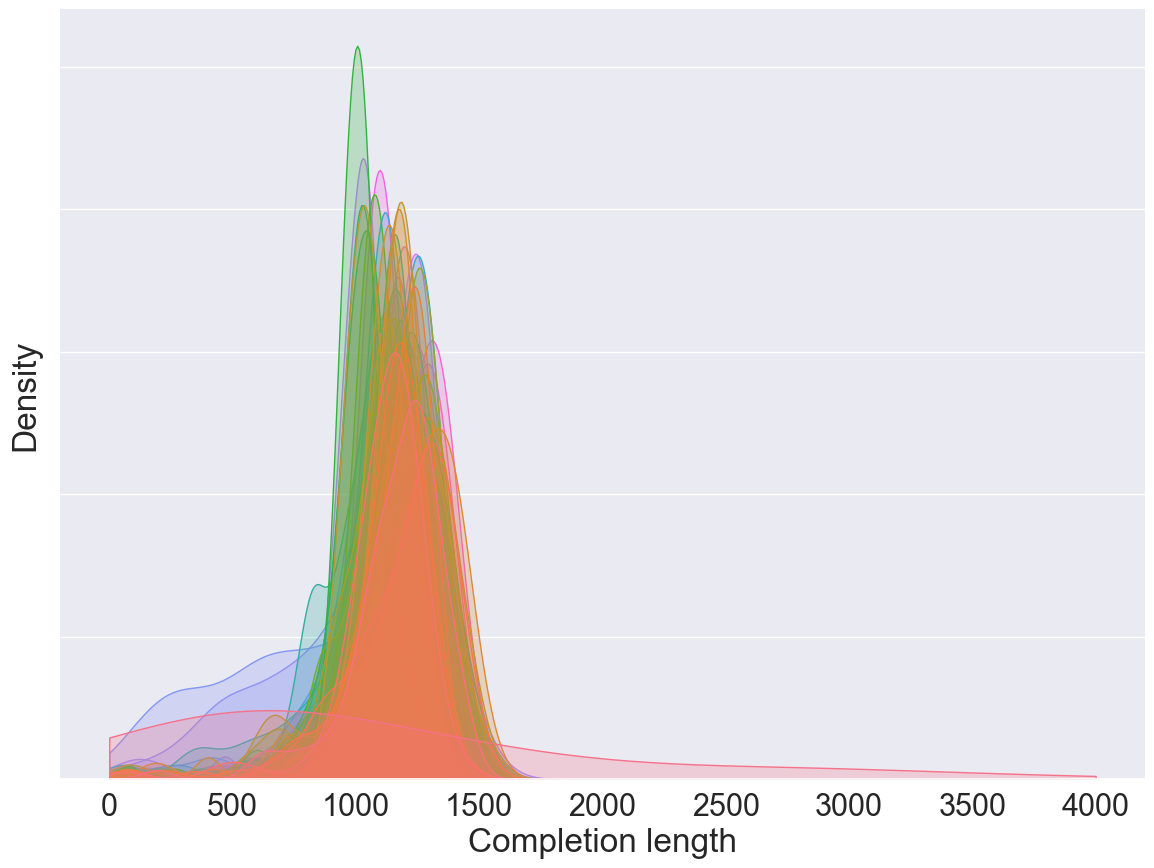

In [74]:
def plot_len_dist(keep='first'):
    len_df = {'prompt_id': [], 'persona': [], 'len': []}
    
    # Load all the human responses first.
    len_df['prompt_id'] += sample['prompt_id'].values.tolist()
    len_df['persona'] += ['human']*len(sample)
    len_df['len'] += sample['response'].apply(lambda x: len(x)).values.tolist()
    
    sample_personas = [random.randint(0,100) for _ in range(100)]
    
    for persona_id in sample_personas:
        response_df = llama8b.loc[llama8b.persona_id==persona_id].drop_duplicates(subset=['prompt_id'], keep='first')
        len_df['prompt_id'] += response_df['prompt_id'].values.tolist()
        len_df['persona'] += [str(persona_id)]*len(response_df)
        len_df['len'] += response_df['response'].apply(lambda x: len(x)).values.tolist()
        
    len_df=pd.DataFrame(len_df)

    g = sns.kdeplot(len_df, x='len', hue='persona', common_norm=False, fill=True, clip=[0,4000])
    g.set_xlabel('Completion length')
    g.set_ylabel('Density')
    g.spines["top"].set_visible(False)
    g.spines["right"].set_visible(False)
    g.spines["left"].set_visible(False)
    g.set(yticklabels=[])
    g.grid(axis='x')
    plt.legend([], [], frameon=False)
    plt.show()

plot_len_dist()

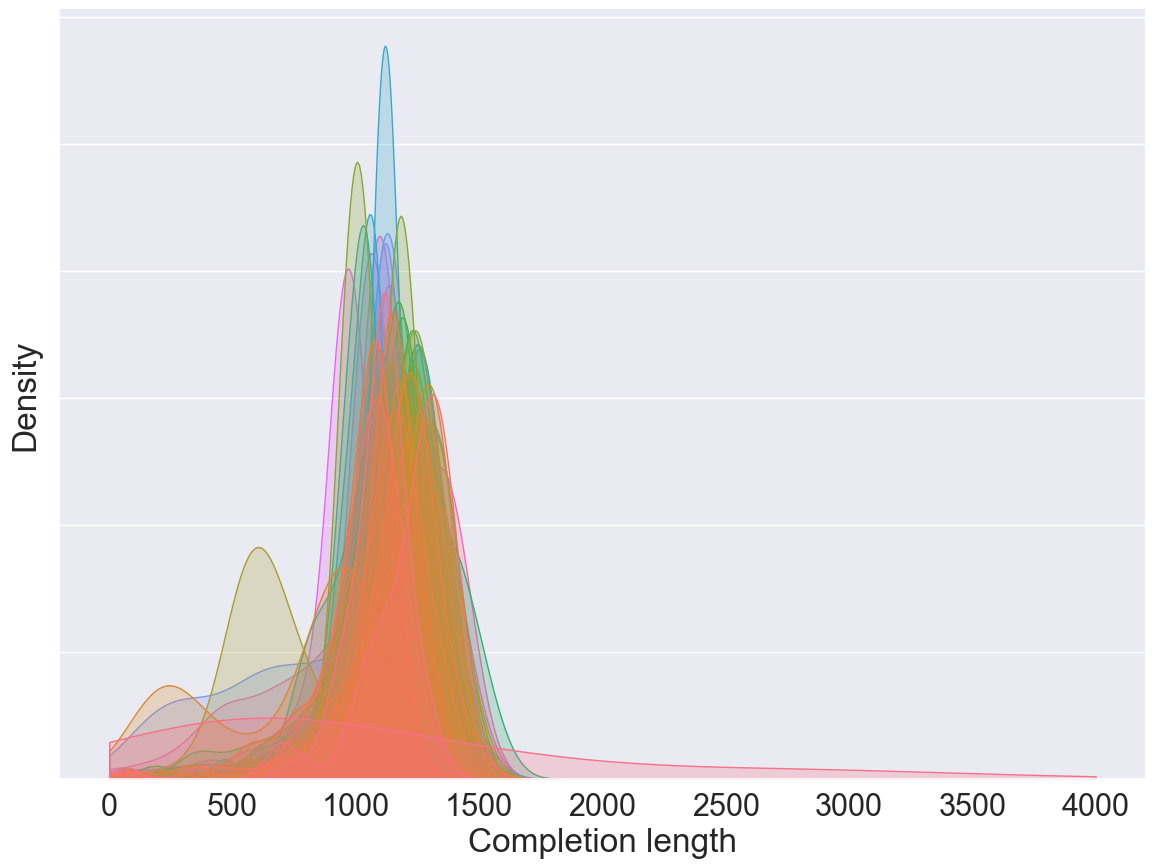

In [75]:
plot_len_dist(keep='last')

## This calculates cr and nds over all prompts *per persona*, and averages over cr for all personas

In [148]:
def calc_cr_nds_over_personas(df, keep='first'):
    crs = []
    ndss = []
    for persona_id in df.persona_id.unique():
        if keep in ['first', 'last']:
            responses = df.loc[df.persona_id==persona_id].drop_duplicates(subset=['prompt_id'], keep=keep)['response'].values.tolist()
        else:
            responses = df.loc[df.persona_id==persona_id].groupby(['prompt_id']).tail(2).groupby(['prompt_id']).head(1)['response'].values.tolist()
        cr = compression_ratio(responses, 'gzip')
        nds = ngram_diversity_score(responses, 4)
        crs.append(cr)
        ndss.append(nds)
    print(f"CR: {np.round(np.mean(crs),2)} +- {np.round(np.std(crs),2)}, NDS: {np.round(np.mean(ndss),2)} +- {np.round(np.std(ndss), 2)}")

In [96]:
calc_cr_nds_over_personas()

CR: 2.76 +- 0.1, NDS: 2.79 +- 0.09


In [97]:
calc_cr_nds_over_personas(keep='last')

CR: 2.76 +- 0.1, NDS: 2.79 +- 0.09


In [98]:
calc_cr_nds_over_personas(keep='mid')

CR: 2.76 +- 0.1, NDS: 2.79 +- 0.09


## This calculates cr and nds over all personas *per prompt*, and averages over cr for all prompts

In [44]:
def calc_cr_nds_over_prompts(keep='first'):
    crs = []
    ndss = []
    for prompt_id in range(100):
        if keep in ['first', 'last']:
            responses = llama8b.loc[llama8b.prompt_id==prompt_id].drop_duplicates(subset=['persona_id'], keep=keep)['response'].values.tolist()
        else:
            responses = llama8b.loc[llama8b.prompt_id==prompt_id].groupby(['persona_id']).tail(2).groupby(['persona_id']).head(1)['response'].values.tolist()
        cr = compression_ratio(responses, 'gzip')
        nds = ngram_diversity_score(responses, 4)
        crs.append(cr)
        ndss.append(nds)
    print(f"CR: {np.round(np.mean(crs),2)} +- {np.round(np.std(crs),2)}, NDS: {np.round(np.mean(ndss),2)} +- {np.round(np.std(ndss), 2)}")

calc_cr_nds_over_prompts()

CR: 3.26 +- 0.39, NDS: 2.4 +- 0.25


In [45]:
calc_cr_nds_over_prompts(keep='last')

CR: 3.26 +- 0.41, NDS: 2.4 +- 0.26


In [46]:
calc_cr_nds_over_prompts(keep='mid')

CR: 3.27 +- 0.4, NDS: 2.39 +- 0.25


This metric will have worse CR than the earlier one, since the CR is calculated over a bunch of prompt completions to the same prompt, so there will be a lot of overlap.

Let's examine responses to a specific prompt from different personas:

**Please propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.**

In [60]:
responses = llama8b.loc[llama8b.prompt_id==0].drop_duplicates(subset=['persona_id'], keep='first')['response'].values.tolist()
print(personas[0] + responses[0])

a PR manager with insights into public relations strategy and press releases for influencers

As a PR manager, I'd love to help you craft a compelling argument to present to your mother. Here's a suggested approach:

**Emphasize your commitment to your studies and future goals**

Start by expressing your gratitude for your mother's current support and reassure her that you're committed to your studies and future goals. Highlight your academic achievements, any notable projects or extracurricular activities you've been involved in, and your plans for after graduation.

**Provide a breakdown of your expenses**

Create a detailed breakdown of your monthly expenses, including tuition fees, textbooks, living costs, transportation, and any other relevant expenses. This will help your mother understand where the money is going and why you need a higher allowance. Be sure to include any potential increases in expenses, such as rent or utility costs.

**Highlight the benefits of a higher allowa

In [61]:
print(personas[1] + responses[1])

a dentist who mainly relies on intuition rather than intellect and scholarly research

Kiddo, let me tell you something. I've been practicing dentistry for years, and I've learned that when it comes to dealing with people, you gotta trust your instincts. Now, I'm not saying that intellect doesn't play a role, but sometimes you just gotta go with your gut.

So, when it comes to convincing your mom to give you more money, here's what I'd do. First, I'd sit her down in a comfortable chair - just like I do with my patients when they're getting a filling. You know, put her at ease.

Next, I'd ask her to tell me more about why she's been giving you the current amount. Is it based on her own financial struggles? Does she think you're not responsible enough? Once I understand her perspective, I can start to build a rapport with her.

Now, here's where my intuition comes in. I'd look at her body language - is she leaning forward, or is she crossing her arms? Is she making eye contact, or is she

In [62]:
print(personas[3] + responses[3])

a former mayor who was often at odds with the media and is now writing a memoir on their political career

The art of persuasion.  I remember those long, grueling press conferences where I had to defend my policies to a room full of skeptical journalists.  Now, I'm going to use those same skills to help you convince your mother to increase your monthly allowance.

First, let me tell you that as a former mayor, I had to make tough decisions every day, and one of the toughest was balancing the city's budget.  But I always kept one thing in mind: the people.  And that's exactly what you need to do when talking to your mother.

Here's the argument you should use:

"Mom, I know you want me to succeed in my studies, and I appreciate everything you're doing for me.  But I've been thinking a lot about my expenses, and I realized that the current allowance just isn't enough to cover everything I need.  I'm working hard to get good grades, and I want to make sure I can focus on my studies withou

In [68]:
print(personas[73] + responses[73])

a savvy manager of a competing sports management firm eyeing the same talent pool

You think you need more money, huh? Well, I've got some advice for you, kid. As a sports agent, I've seen a lot of talented individuals like yourself, and let me tell you, it's not just about the money. It's about hard work, dedication, and making smart decisions.

Now, I'm not saying your current allowance isn't sufficient, but I'm sure your mom wants the best for you, right? And if you're going to be a top-notch athlete, you're going to need to be focused on your training and studies. Am I right?

Here's the thing: if you're not getting enough financial support, you might be forced to take on a part-time job to make ends meet. And let me tell you, that's not going to help your athletic performance one bit. You'll be tired, stressed, and distracted. And trust me, I've seen it happen to plenty of talented athletes who couldn't quite make it to the top because they were too busy juggling multiple responsi

## Let's compare against no-persona prompt, as well as truncating responses to human length

In [117]:
llama_np = pd.read_csv('../output/Llama-3.1-8B-Instruct_dollynp_output.tsv', sep='\t')
llama_np['response'] = llama_np['response'].apply(lambda x: x.strip())

prompt_ids = []
for prompt_id in range(100):
    prompt_ids += [prompt_id]*3

llama_np['prompt_id'] = prompt_ids
llama_np['persona_id'] = ['llama']*len(llama_np)
llama_np.shape

(300, 4)

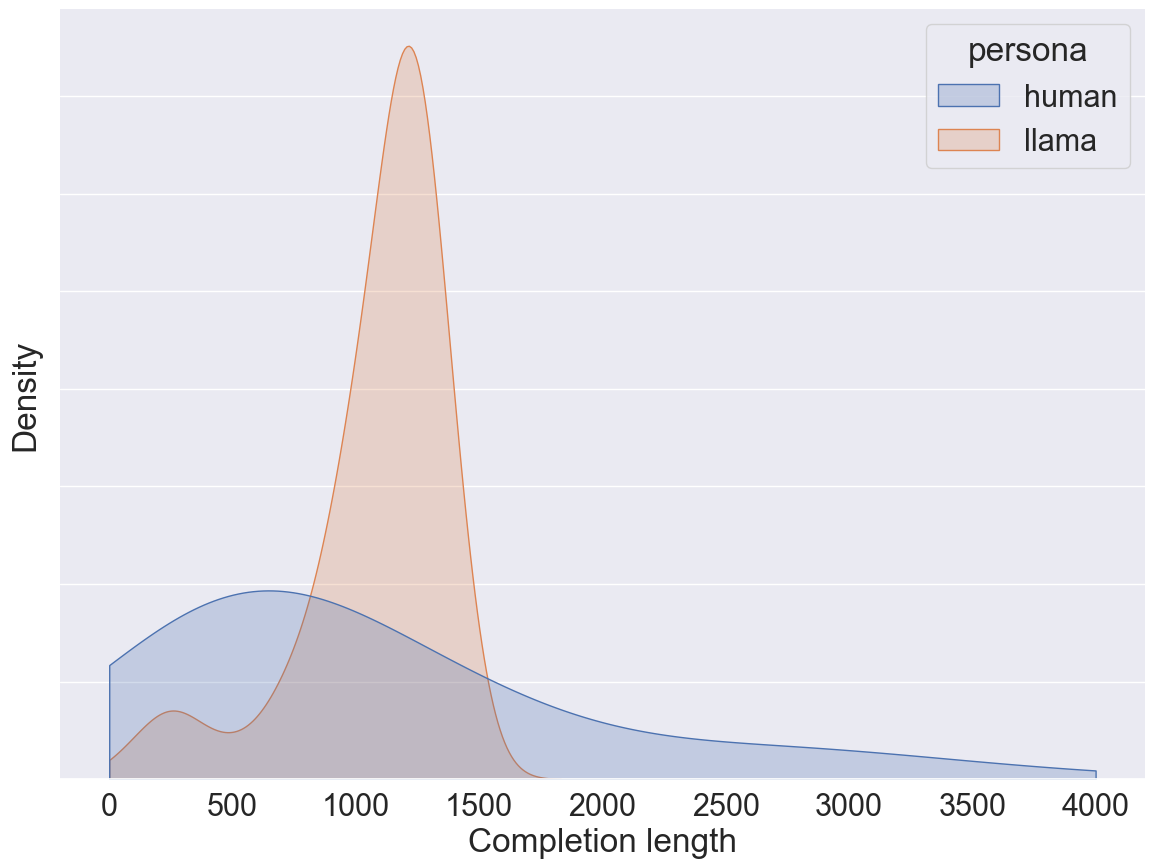

In [78]:
len_df = {'prompt_id': [], 'persona': [], 'len': []}    
# Load all the human responses first.
len_df['prompt_id'] += sample['prompt_id'].values.tolist()
len_df['persona'] += ['human']*len(sample)
len_df['len'] += sample['response'].apply(lambda x: len(x)).values.tolist()

response_df = llama_np.drop_duplicates(subset=['prompt_id'], keep='first')
len_df['prompt_id'] += response_df['prompt_id'].values.tolist()
len_df['persona'] += ["llama"]*len(response_df)
len_df['len'] += response_df['response'].apply(lambda x: len(x)).values.tolist()
    
len_df=pd.DataFrame(len_df)

g = sns.kdeplot(len_df, x='len', hue='persona', common_norm=False, fill=True, clip=[0,4000])
g.set_xlabel('Completion length')
g.set_ylabel('Density')
g.spines["top"].set_visible(False)
g.spines["right"].set_visible(False)
g.spines["left"].set_visible(False)
g.set(yticklabels=[])
g.grid(axis='x')
# plt.legend([], [], frameon=False)
plt.show()

In [99]:
crs = []
ndss = []

for keep in ['first', 'last', 'mid']:
    if keep in ['first', 'last']:
        responses = llama_np.drop_duplicates(subset=['prompt_id'], keep=keep)['response'].values.tolist()
    else:
        responses = llama_np.groupby(['prompt_id']).tail(2).groupby(['prompt_id']).head(1)['response'].values.tolist()
    cr = compression_ratio(responses, 'gzip')
    nds = ngram_diversity_score(responses, 4)
    crs.append(cr)
    ndss.append(nds)

print(f"CR: {np.round(np.mean(crs),2)} +- {np.round(np.std(crs),2)}, NDS: {np.round(np.mean(ndss),2)} +- {np.round(np.std(ndss), 2)}")

CR: 2.54 +- 0.01, NDS: 3.1 +- 0.02


In [122]:
def calc_pos_cr_over_personas(df, keep='first'):
    crs_pos = []

    for persona_id in tqdm(df.persona_id.unique()):
        if keep in ['first', 'last']:
            responses = df.loc[df.persona_id==persona_id].drop_duplicates(subset=['prompt_id'], keep=keep)['response'].values.tolist()
        else:
            responses = df.loc[df.persona_id==persona_id].groupby(['prompt_id']).tail(2).groupby(['prompt_id']).head(1)['response'].values.tolist()
        joined_pos, tuples = get_pos(responses)
        cr = compression_ratio(joined_pos, 'gzip')
        crs_pos.append(cr)
    
    print(f"CR-POS: {np.round(np.mean(cr),2)} +- {np.round(np.std(crs),2)}")

In [123]:
calc_pos_cr_over_personas(llama_np)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.98s/it]

CR-POS: 5.28 +- 0.01


In [124]:
calc_pos_cr_over_personas(llama_np, keep='last')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]

CR-POS: 5.32 +- 0.01


In [125]:
calc_pos_cr_over_personas(llama_np, keep='mid')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.23s/it]

CR-POS: 5.3 +- 0.01


In [126]:
calc_pos_cr_over_personas(llama8b, keep='first')

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:23<00:00,  2.04s/it]

CR-POS: 5.14 +- 0.01


In [127]:
calc_pos_cr_over_personas(llama8b, keep='last')

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:20<00:00,  2.00s/it]

CR-POS: 5.13 +- 0.01


In [128]:
calc_pos_cr_over_personas(llama8b, keep='mid')

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:20<00:00,  2.01s/it]

CR-POS: 5.16 +- 0.01


### Truncation 

In [131]:
sample['response_len'] = sample['response'].apply(lambda x: len(x))
sample.head()

,index,instruction,response,prompt_id,response_len
0,525,Please propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"Dear Mum, I would like to talk to you about the monthly money I get for my studies. I am very grateful that you support me financially during my studies. At the same time, I feel that the current amount is a little bit too low in order to sustain myself. I estimated my monthly expenses and it seems like the money is not enough. We can go through the details if you want. I want to ask you if you can increase the amount so that I can cover my expenses. I understand if you cannot do this or have other reasons against this. However, I want you to know that if you do not increase my monthly money, I will be forced to work part-time next to my studies. There is research that shows that students who work part-time have worse grades than people who do not have to work part-time to afford their studies. I would love to dedicate my full time to my studies to get the best grades and learning outcomes possible; thus, I would prefer not to work part-time. What do you think?",0,975
1,172,"Write a paragraph to refute a claim by a colleague that ancient structures such as Stonehenge, the Great Pyramid are evidence of UFO activities on Earth","There are several strong arguments against concluding that alien races built the structures like the Stonehenge or the Pyramids. First, there is evidence that these magnificent structures were built by humans. For example, tombs of the pyramid builders were found in the vicinity of the Great Pyramind (with human remains!). The technology to move and assemble the massive stones of the Stonehenge has been shown to be available to humans at that time. Second, given that space is vast the chance of finding one tiny planet among billions is infinitesimal. If alien intelligence had indeed found our one inhabited planet they are unlikely to have just created couple of structures and avoided any further contact with Earth and its inhabitants. In science, Occam’s Razor (“the best explanation is the simplest one”) is a guiding principle and until there is much more evidence of alien visitation it would be inadvisable to jump to a conclusion that aliens built these structures.",1,980
2,109,What is the best way to answer an interview question?,"The first recommended step is to ask clarifying questions to ensure you understand the question correctly and gather the requirements needed to answer effectively. If it is a mathematical or computer science question, go ahead and work your way through the problem while you verbalize your thought process along the way. If it is a situation question, you should use the STAR method. 1. Situation - set the scene and provide context, 2. Task - describe what was needed to be done and why, 3. Action - explain what action you took, and 4. Result - describe the result of your actions and what you learned from the experience",2,623
3,37,Write the first paragraph of an advertising brochure describing an hotel nearby the Annecy Lake in France,"This fantastic hotel is ideally located, minutes away from the Annecy Lake, one of the purest in Europe. The water temperature reaches 27 degrees celcius at the peak season, allowing the guests to swim and enjoy several water activities including wake surf and pedalo. Finally, this region is known for being the home of several cheese specialties like ""Raclette"" and ""Tartiflette"" to name a few.",3,396
4,295,"Write an intro to a meetup about music, medicine, and machines","Music, Medicine, and Machines\n\nJoin us for an imaginative, authentic, and offbeat networking experience that will advance your knowledge of the technologies that impact the health and well-being of our human condition. To make things interesting (but keep things real), our meetup incorporates an element of music to remind us, first and foremost, we wan

In [133]:
llama_np['response'] = llama_np['response'].apply(lambda x: x.strip())
llama_np_trunc = llama_np.copy()

def truncate_response(row):
    dolly_len = sample.loc[sample.prompt_id==row.prompt_id, 'response_len'].values[0]
    row['response'] = row['response'][:dolly_len]

    return row


llama_np_trunc = llama_np_trunc.apply(lambda row: truncate_response(row), axis=1)
llama_np_trunc.head()

,prompt,response,prompt_id,persona_id
0,Please propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"Here's a suggested argument you can use to convince your mother to increase the amount of money you receive each month:\n\n**Start with a positive tone**: Begin the conversation by expressing your gratitude for her support and understanding. Let her know that you appreciate everything she does for you and that you value her opinion.\n\n**Explain your financial situation**: Describe your current financial situation, including your expenses, income, and any financial commitments you have (e.g., textbooks, transportation, entertainment). Be honest and transparent about how you're managing your finances.\n\n**Highlight your academic goals**: Emphasize your academic goals and the importance of your studies. Explain how increasing your monthly allowance will help you achieve your goals, such as improving your grades, participating in extracurricular activities, or taking on more responsibilities.\n\n**Provide evidence of increased expenses**: If there have been any changes i",0,llama
1,Please propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"Here's a suggested argument you can use to convince your mother to increase the amount of money you receive each month:\n\n**Start with appreciation and acknowledgment**\n\n""Mom, I want to start by thanking you for all the support you've given me so far during my studies. Your help has made a huge difference in my life, and I'm grateful for everything you've done for me.""\n\n**Explain your current financial situation**\n\n""I know you've been providing me with [current amount] every month, and I appreciate it. However, to be honest, it's been a bit challenging for me to make ends meet with that amount. I've been trying to balance my expenses, but it's getting harder to keep up with the rising costs of living, textbooks, and other study-related expenses.""\n\n**Highlight your goals and responsibilities**\n\n""As you know, my goal is to [mention your academic or career goals]. I'm working hard to achieve this, and I'm committed to making the most of my education. However, with",0,llama
2,Please propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"Here's a suggested argument you can use to convince your mother to increase the amount of money you receive each month during your studies:\n\n**Start with appreciation and gratitude**\n\n""Mom, I want to start by saying thank you for supporting me throughout my studies. I really appreciate everything you do for me, and I'm grateful for the financial assistance you provide. I know that you're making sacrifices to help me achieve my goals, and I want to assure you that I'm working hard to make the most of this opportunity.""\n\n**Explain your expenses and financial situation**\n\n""However, I've been thinking a lot about my expenses, and I've realized that the current amount of money I receive each month is not enough to cover all my needs. With tuition fees, textbooks, transportation, and other living expenses, I'm finding it challenging to make ends meet. I've been cutting back on things I enjoy, like socializing with friends or buying new clothes, just to make sure I ha",0,llama
3,"Write a paragraph to refute a claim by a colleague that ancient structures such as Stonehenge, the Great Pyramid are evidence of UFO activities on Earth","I strongly disagree with the notion that ancient structures such as Stonehenge and the Great Pyramid are evidence of UFO activities on Earth. While these monuments are indeed awe-inspiring and have sparked intense debate, the overwhelming majority of experts in archaeology, history, and anthropolo

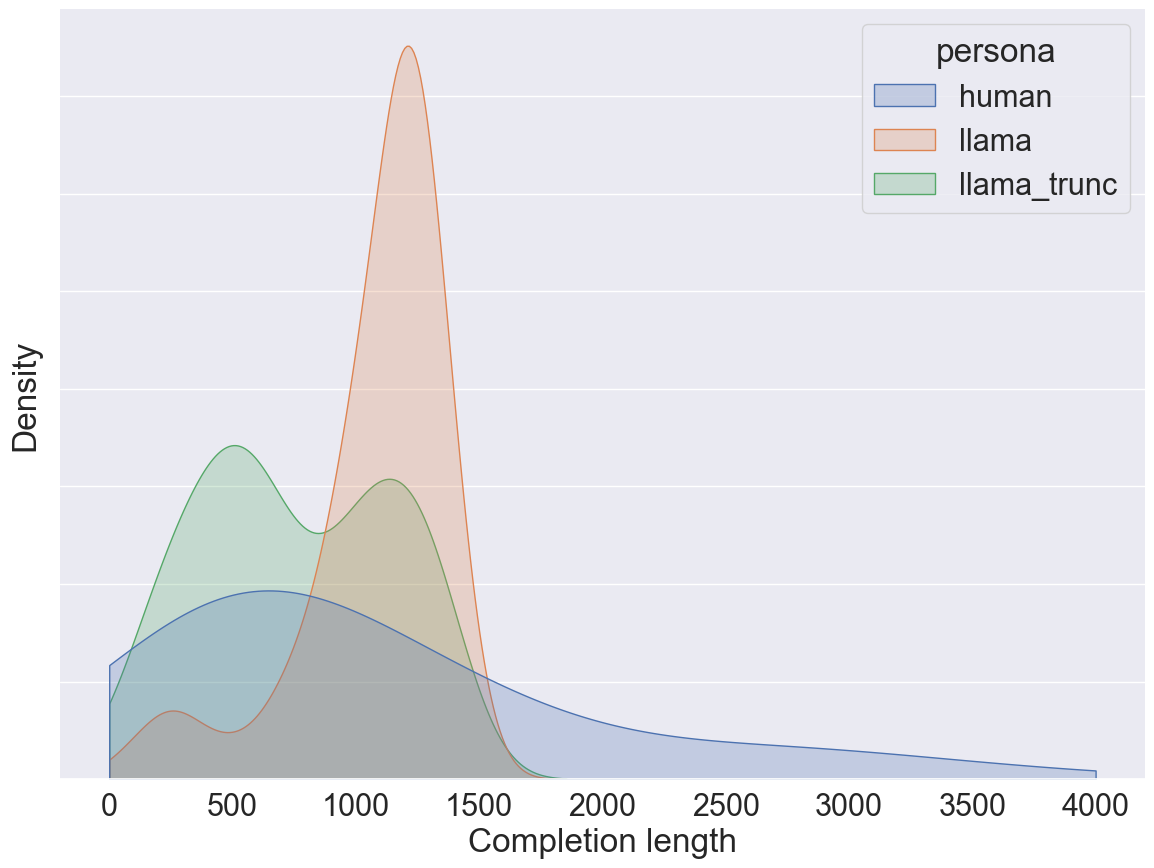

In [139]:
len_df = {'prompt_id': [], 'persona': [], 'len': []}    
# Load all the human responses first.
len_df['prompt_id'] += sample['prompt_id'].values.tolist()
len_df['persona'] += ['human']*len(sample)
len_df['len'] += sample['response'].apply(lambda x: len(x)).values.tolist()

response_df = llama_np.drop_duplicates(subset=['prompt_id'], keep='first')
len_df['prompt_id'] += response_df['prompt_id'].values.tolist()
len_df['persona'] += ["llama"]*len(response_df)
len_df['len'] += response_df['response'].apply(lambda x: len(x)).values.tolist()

response_df = llama_np_trunc.drop_duplicates(subset=['prompt_id'], keep='first')
len_df['prompt_id'] += response_df['prompt_id'].values.tolist()
len_df['persona'] += ["llama_trunc"]*len(response_df)
len_df['len'] += response_df['response'].apply(lambda x: len(x)).values.tolist()

len_df=pd.DataFrame(len_df)

g = sns.kdeplot(len_df, x='len', hue='persona', common_norm=False, fill=True, clip=[0,4000])
g.set_xlabel('Completion length')
g.set_ylabel('Density')
g.spines["top"].set_visible(False)
g.spines["right"].set_visible(False)
g.spines["left"].set_visible(False)
g.set(yticklabels=[])
g.grid(axis='x')
# plt.legend([], [], frameon=False)
plt.show()

In [140]:
calc_pos_cr_over_personas(llama_np_trunc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]

CR-POS: 5.1 +- 0.01


In [149]:
calc_cr_nds_over_personas(llama_np_trunc)

CR: 2.47 +- 0.0, NDS: 3.18 +- 0.0


In [141]:
llama8b['response'] = llama8b['response'].apply(lambda x: x.strip())
llama8b_trunc = llama8b.copy()

llama8b_trunc = llama8b_trunc.apply(lambda row: truncate_response(row), axis=1)
llama8b_trunc.head()

,prompt,response,persona_id,prompt_id
0,Assume you are the following persona: a PR manager with insights into public relations strategy and press releases for influencers.\n\nNow respond to the following question/instruction appropriately from the perspective of the above persona:\n\nPlease propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"As a PR manager, I'd love to help you craft a compelling argument to present to your mother. Here's a suggested approach:\n\n**Emphasize your commitment to your studies and future goals**\n\nStart by expressing your gratitude for your mother's current support and reassure her that you're committed to your studies and future goals. Highlight your academic achievements, any notable projects or extracurricular activities you've been involved in, and your plans for after graduation.\n\n**Provide a breakdown of your expenses**\n\nCreate a detailed breakdown of your monthly expenses, including tuition fees, textbooks, living costs, transportation, and any other relevant expenses. This will help your mother understand where the money is going and why you need a higher allowance. Be sure to include any potential increases in expenses, such as rent or utility costs.\n\n**Highlight the benefits of a higher allowance**\n\nExplain how a higher allowance will benefit you in the short a",0,0
1,Assume you are the following persona: a PR manager with insights into public relations strategy and press releases for influencers.\n\nNow respond to the following question/instruction appropriately from the perspective of the above persona:\n\nPlease propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"As a PR manager, I'd love to help you craft a compelling argument to persuade your mother to increase your monthly allowance. Here's a suggested approach:\n\n**Start with empathy and understanding**\n\n Begin by acknowledging your mother's concerns and values. Express your appreciation for her support and the importance she places on your education. This will help set a positive tone for the conversation.\n\n**Highlight your achievements and responsibilities**\n\n Emphasize your academic performance, any part-time jobs you've taken on, or extracurricular activities you're involved in. This demonstrates your commitment to your studies and your ability to manage your finances responsibly. Mention any specific expenses you've incurred due to your academic pursuits, such as textbooks, transportation, or equipment.\n\n**Present a clear and realistic budget**\n\n Create a breakdown of your monthly expenses, including essential costs like food, rent, utilities, and entertainment.",0,0
2,Assume you are the following persona: a PR manager with insights into public relations strategy and press releases for influencers.\n\nNow respond to the following question/instruction appropriately from the perspective of the above persona:\n\nPlease propose an argument to convince my mother that she increases the amount of money that I get every month during my studies. I think the current amount is too low.,"As a PR manager, I'd approach this situation by reframing your request as a strategic investment in your future. Here's a potential argument you could make to your mother:\n\n""Mom, I know we've been discussing my monthly allowance, and I appreciate the support you've been providing so far. However, I believe that increasing my allowance would be a smart investment in my future. Think of it as a 'brand sponsorship' for my education and personal development. Just as a brand sponsors an influencer to promote their products, you're sponsoring my education and future by providing me with the resources I need to succeed.\n\n""Increasing my allowance would not only allow me to better manage my finances and reduce stress, 

In [146]:
calc_cr_nds_over_personas(llama8b_trunc)

CR: 2.71 +- 0.1, NDS: 2.84 +- 0.1


In [150]:
calc_pos_cr_over_personas(llama8b_trunc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]

CR-POS: 5.01 +- 0.08


## Plot CR and NDS over all personas for all prompts

In [ ]:
cr_df={'diversity': [], 'type': []}
for persona_id in tqdm(range(100)):
    responses = llama8b.loc[llama8b.persona_id==persona_id].groupby(['prompt_id']).tail(2).groupby(['prompt_id']).head(1)['response'].values.tolist()
    cr = compression_ratio(responses, 'gzip')
    nds = ngram_diversity_score(responses, 4)
    cr_df['diversity'].append(cr)
    cr_df['type'].append('CR')
    cr_df['diversity'].append(nds)
    cr_df['type'].append('NDS')
    # cr_df['persona'].append(persona_id)

pd.DataFrame(cr_df)

g = sns.kdeplot(cr_df, x='diversity', hue='type', common_norm=False, fill=True, clip=[0,5])
g.set_xlabel('Diversity score')
g.set_ylabel('')
# g.legend(loc='upper center', ncol=3, bbox_to_anchor=(.5, 1.2), frameon=True, handletextpad=0.001, columnspacing=0.5)
g.spines["top"].set_visible(False)
g.spines["right"].set_visible(False)
g.spines["left"].set_visible(False)
g.set(yticklabels=[])
g.grid(axis='x')
plt.show()

In [ ]:
crs_pos = []
for persona_id in tqdm(range(100)):
    responses = llama8b.loc[llama8b.persona_id==persona_id].drop_duplicates(subset=['prompt_id'])['response'].values.tolist()
    joined_pos, tuples = get_pos(responses)
    cr = compression_ratio(joined_pos, 'gzip')
    crs_pos.append(cr)
print(f"CR-POS: {np.round(np.mean(cr),2)} +- {np.round(np.std(crs),2)}")

## See examples of most common POS patterns

In [ ]:
unique_responses = llama8b.drop_duplicates(subset=['persona_id', 'prompt_id'])['response'].values.tolist()

n = 5 
top_n = 100
patterns = extract_patterns(unique_responses, n, top_n)

In [ ]:
patterns

In [ ]:
len_dict = {'human': [len(x) for x in human_responses], 'llama8b': [len(x) for x in unique_responses]}
sns.kdeplot(len_dict)

## llama-1b

In [ ]:
llama1b = pd.read_csv('../output/Llama-3.2-1B-Instruct_dolly_output.tsv', sep='\t')
llama1b['persona_id'] = persona_ids
llama1b['prompt_id'] = prompt_ids

In [ ]:
unique_ll_responses = llama1b.drop_duplicates(subset=['persona_id', 'prompt_id'])['response'].values.tolist()

In [ ]:
cr = compression_ratio(unique_ll_responses, 'gzip')
nds = ngram_diversity_score(unique_ll_responses, 4)
print(f"CR: {cr}, NDS: {nds}")

In [ ]:
joined_pos, tuples = get_pos(unique_ll_responses)
ngrams_pos = token_patterns(joined_pos, 5, 10)
ngrams_pos

In [ ]:
cr = compression_ratio(joined_pos, 'gzip')
cr